In [1]:
%matplotlib inline
from gurobipy import *
from scipy.stats import poisson
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


c:\Users\Johnson\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Johnson\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
c:\Users\Johnson\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\Johnson\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# 將資料整合至一個 dataframe
raw_df = pd.DataFrame()
files = os.listdir('data')
for f in files:
    if 'item' not in f:
        df = pd.read_csv('data/{}'.format(f))
        raw_df = pd.concat([raw_df, df])

In [3]:
# 去除 unit_sales 中有小數或負數的品項
integer_items = []
item_dfs = list(raw_df.groupby('item_nbr'))

for item_df in item_dfs:
    stop = False
    for us in item_df[1]['unit_sales']:
        if (us.is_integer() != True) or (us < 0):
            stop = True
            break
    if stop:
        continue
    integer_items.append(item_df[0])
    

In [4]:
# 函式庫
def get_decisions(day, model):

    # 用測試資料的模型預測值計算CDF
    F = {}
    for i in N:
        for d in list(range(U[i]+1)):
            item_nbr = integer_items[i]
            if model == 'poisson':
                F[i, d] = poisson.cdf(k = d, 
                                    mu = poisson_pred_df['pred'].loc[(poisson_pred_df['item_nbr']==item_nbr) & (poisson_pred_df['day']==day)].values[0])

    # 建立模型
    m = Model("freshfood_newsvendor")
    
    # 不顯示執行結果
    m.setParam('OutputFlag', 0)
    
    # 決策變數
    q = m.addVars(N, vtype = GRB.INTEGER, name='q')
    z_varnames = []
    for i in N:
        for d in list(range(L[i]+1, U[i]+1)):
            z_varnames.append((i, d))
    z = m.addVars(z_varnames, vtype = GRB.BINARY, name='z')

    # 更新模型
    m.update()

    # quicksum()等於加總符號sigma
    # 目標函式
    m.setObjective(quicksum((p[i] - c[i]) * q[i] - 
                (p[i] * quicksum(F[i, d] for d in range(L[i])) + 
                    quicksum(p[i] * F[i, d] * z[i, d+1] for d in range(L[i], U[i]))) for i in N), 
                sense = GRB.MAXIMIZE)

    # 限制式
    m.addConstrs(q[i] >= L[i] for i in N)
    m.addConstrs(q[i] <= U[i] for i in N)

    m.addConstrs(quicksum(r[i, j] * q[i] for i in N) <= R[j]  for j in J)

    m.addConstrs(q[i] == L[i] + quicksum(z[i, d] for d in range(L[i]+1, U[i]+1)) for i in N)

    m.addConstrs(z[i, d-1] >= z[i, d] for i in N
                                    for d in range(L[i]+2, U[i]+1))

    # 開始最佳化運算
    m.optimize()

    # 印出模型 
    # print (m.display())
    # for v in m.getVars():
    #     print('%s %g' %(v.varName, v.x))

    # print('Obj: %g' % m.objVal)
    
    # 儲存模型
    # m.write('mip1.lp')
    
    # 每個品項的最佳訂購量
    decisions = []
    for i in N:
        decisions.append([var for var in m.getVars() if "q[{}]".format(i) in var.VarName][0].X)


    return decisions

def get_poisson_mu(item_nbr, from_date, to_date, test_date):
    
    # 訓練集
    train_data = df.loc[(df['item_nbr']==item_nbr) & (df['date']>=from_date) & (df['date']<=to_date)]
    X_train = train_data.iloc[:, 8:]
    y_train = train_data[['unit_sales']]

    # 測試集
    test_data = df.loc[(df['item_nbr']==item_nbr) & (df['date']>to_date) & (df['date']<=test_date)]
    X_test = test_data.iloc[:, 8:]
    y_test = test_data[['unit_sales']]

    # 訓練poisson regression模型
    poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    pred = poisson_model.predict(X_test)
    
    # 將預測結果放入poisson_pred_df
    result_df = pd.DataFrame(pred, columns=['pred'])
    result_df['item_nbr'] = item_nbr
    result_df = result_df.reset_index(drop=True).reset_index()
    result_df.rename(columns={'index':'day'}, inplace=True)

    global poisson_pred_df
    poisson_pred_df = pd.concat([poisson_pred_df, result_df], axis=0)

def cal_mse(item_nbr, model):
    
    # 查看模型的MSE
    y_true = actual_sales['unit_sales'].loc[actual_sales['item_nbr']==item_nbr]
    if model == 'poisson':
        y_pred = poisson_pred_df['pred'].loc[poisson_pred_df['item_nbr']==item_nbr]
 
  
    return mean_squared_error(y_true, y_pred)



In [5]:
# 定義變數
# 用2014年的資料當訓練集，並用2015年的前180天的資料當測試集
from_date = '2014-01-01'
to_date = '2014-12-31'
test_day = 180
test_date = (datetime.datetime.strptime(to_date, "%Y-%m-%d") + datetime.timedelta(days=test_day)).strftime("%Y-%m-%d")

raw_df['month'] = raw_df['date'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d').month)
df = pd.get_dummies(raw_df, columns=['weekday', 'month', 'type'], drop_first=True)
poisson_pred_df = pd.DataFrame()

p = [30, 50, 60, 70, 50, 40, 20, 60, 80, 100]
c = [20, 30, 40, 50, 20, 30, 10, 40, 50, 60]

# 訂購數量下限
L = []
for item_nbr in integer_items[:10]:
    all_data = df.loc[(df['item_nbr']==item_nbr) & (df['date']>=from_date) & (df['date']<=test_date)]
    L.append(int(np.percentile(all_data['unit_sales'], 5)))

# 訂購數量上限
U = []
for item_nbr in integer_items[:10]:
    all_data = df.loc[(df['item_nbr']==item_nbr) & (df['date']>=from_date) & (df['date']<=test_date)]
    U.append(int(np.percentile(all_data['unit_sales'], 95)))

R = [sum(U)]
J = list(range(1))
N = list(range(10))

# 每個品項所占資源單位
r = {}
for i in N:
    for j in J:
        r[i, j] = 1


c:\Users\Johnson\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\Johnson\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\Johnson\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


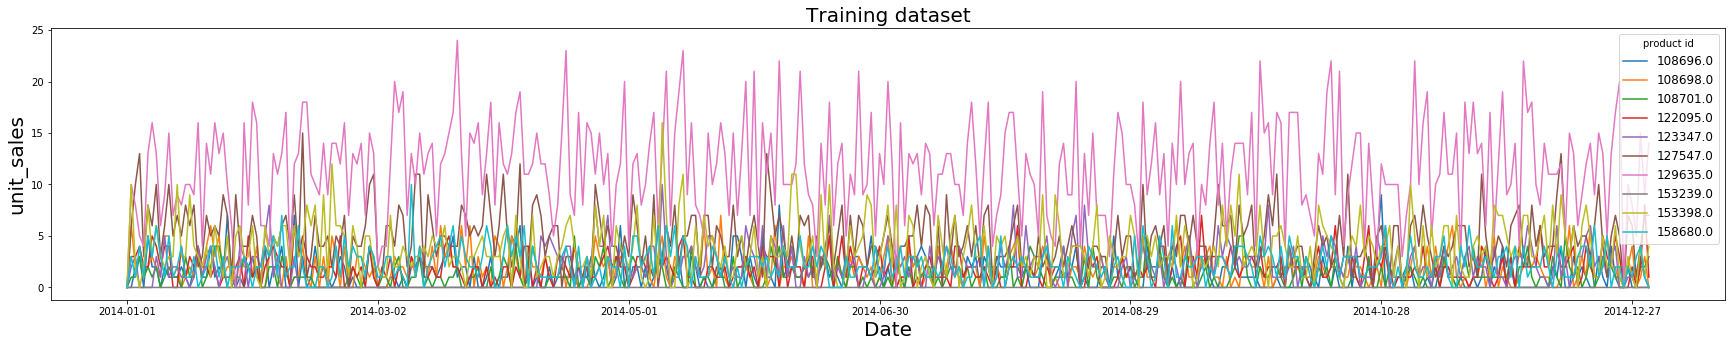

In [6]:
# 畫出訓練資料長相
fig, ax = plt.subplots(figsize = (30, 5))

for item_nbr in integer_items[:10]:
    train_data = df.loc[(df['item_nbr']==item_nbr) & (df['date']>=from_date) & (df['date']<=to_date)]
    X = train_data['date']
    y = train_data['unit_sales']

    ax.plot(X, y, label = item_nbr)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))    
    
plt.xlabel('Date', size = 20)
plt.ylabel('unit_sales', size = 20)
plt.title('Training dataset', size = 20)
plt.legend(title='product id', fontsize = 12)

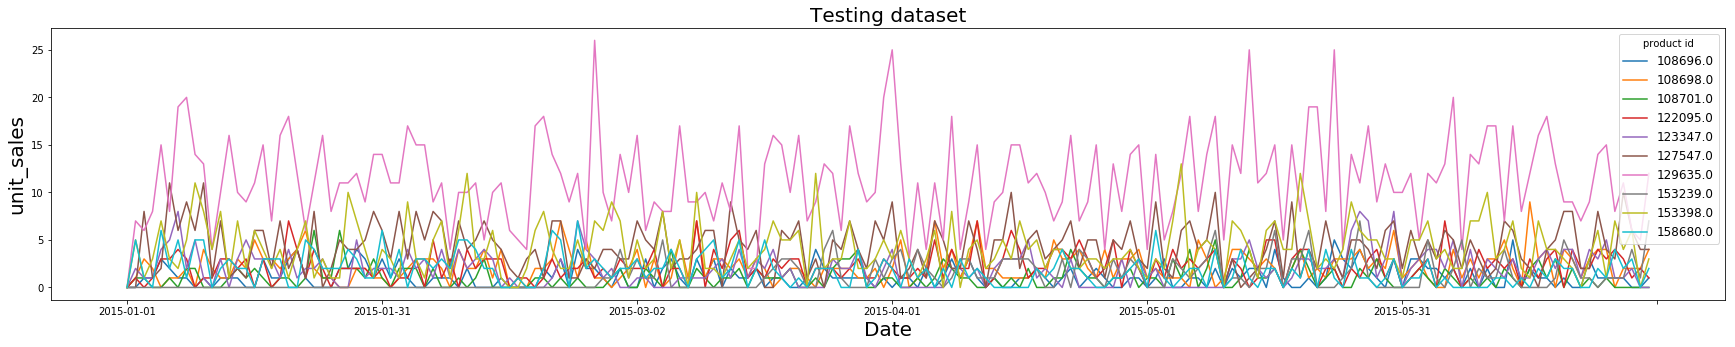

In [7]:
# 畫出測試資料長相
fig, ax = plt.subplots(figsize = (30, 5))

for item_nbr in integer_items[:10]:
    test_data = df.loc[(df['item_nbr']==item_nbr) & (df['date']>to_date) & (df['date']<=test_date)]
    X = test_data['date']
    y = test_data['unit_sales']

    ax.plot(X, y, label = item_nbr)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(30))    
    
plt.xlabel('Date', size = 20)
plt.ylabel('unit_sales', size = 20)
plt.title('Testing dataset', size = 20)
plt.legend(title='product id', fontsize = 12, loc = 'upper right')

In [8]:
# 得出每個品項在未來180天的預測值
for item_nbr in integer_items[:10]:
    get_poisson_mu(item_nbr, from_date, to_date, test_date)

In [9]:
# 將真實銷售數據放入 actual_sales
actual_sales = pd.DataFrame()
for item_nbr in integer_items[:10]:
    test_data = df.loc[(df['item_nbr']==item_nbr) & (df['date']>to_date) & (df['date']<=test_date)]
    y_test = pd.DataFrame(test_data[['unit_sales']])
    y_test['item_nbr'] = item_nbr
    y_test = y_test.reset_index(drop=True).reset_index()
    y_test.rename(columns={'index':'day'}, inplace=True)

    actual_sales = pd.concat([actual_sales, y_test], axis=0)

In [10]:
# 進行最佳化
poisson_decisions = []

for day in range(test_day):
    poisson_decisions.append(get_decisions(day, 'poisson'))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-10


### Poisson 實驗結果

##### Poisson 訂購max(min(E(y|x), U), L)


In [12]:
poisson_profits = []
poisson_lostsales = pd.DataFrame()
for day in range(test_day):
    day_profit = []
    day_lostsale = []
    for i in N:
        order = round(max(min(poisson_pred_df['pred'].loc[(poisson_pred_df['item_nbr']==integer_items[i]) & (poisson_pred_df['day']==day)].values[0], U[i]), L[i]))
        actual_sale = actual_sales['unit_sales'].loc[(actual_sales['item_nbr']==integer_items[i]) & (actual_sales['day']==day)].values[0]
        day_profit.append(p[i] * min(actual_sale, order) - c[i] * order)

        day_lostsale.append([day, integer_items[i], p[i], order, actual_sale, max(actual_sale - order, 0)])
        
    poisson_profits.append(day_profit)
    day_lostsale = pd.DataFrame(day_lostsale, columns=['day', 'item_nbr', 'price', 'order', 'actual_sale', 'lost_sales'])
    poisson_lostsales = pd.concat([poisson_lostsales, day_lostsale])

poisson_lostsales['lost_sales*price'] = poisson_lostsales['price'] * poisson_lostsales['lost_sales']

In [13]:
total_poisson_profit = sum(sum(profit) for profit in poisson_profits)
print('總利潤: {}'.format(total_poisson_profit))

print('總銷售損失(數量): {}'.format(sum(poisson_lostsales['lost_sales'])))
print('總銷售損失(數量*售價): {}'.format(sum(poisson_lostsales['lost_sales*price'])))


總利潤: 27610.0
總銷售損失(數量): 1515.0
總銷售損失(數量*售價): 77930.0


##### Poisson最佳訂購量


In [14]:
poisson_opti_profits = []
poisson_opti_lostsales = pd.DataFrame()

for day in range(test_day):
    day_profit = []
    day_lostsale = []
    for i in N:
        order = poisson_decisions[day][i]
        actual_sale = actual_sales['unit_sales'].loc[(actual_sales['item_nbr']==integer_items[i]) & (actual_sales['day']==day)].values[0]
        day_profit.append(p[i] * min(actual_sale, order) - c[i] * order)
        
        day_lostsale.append([day, integer_items[i], p[i], order, actual_sale, max(actual_sale - order, 0)])
        
    poisson_opti_profits.append(day_profit)
    day_lostsale = pd.DataFrame(day_lostsale, columns=['day', 'item_nbr', 'price', 'order', 'actual_sale', 'lost_sales'])
    poisson_opti_lostsales = pd.concat([poisson_opti_lostsales, day_lostsale])

poisson_opti_lostsales['lost_sales*price'] = poisson_opti_lostsales['price'] * poisson_opti_lostsales['lost_sales']

In [15]:
# for day in range(test_day):
#     print('第{}天的利潤: {}'.format(day, poisson_opti_profits[day]))
total_poisson_opti_profit = sum(sum(profit) for profit in poisson_opti_profits)
print('總利潤: {}'.format(total_poisson_opti_profit))

print('總銷售損失(數量): {}'.format(sum(poisson_opti_lostsales['lost_sales'])))
print('總銷售損失(數量*售價): {}'.format(sum(poisson_opti_lostsales['lost_sales*price'])))

總利潤: 36440.0
總銷售損失(數量): 2037.0
總銷售損失(數量*售價): 107610.0


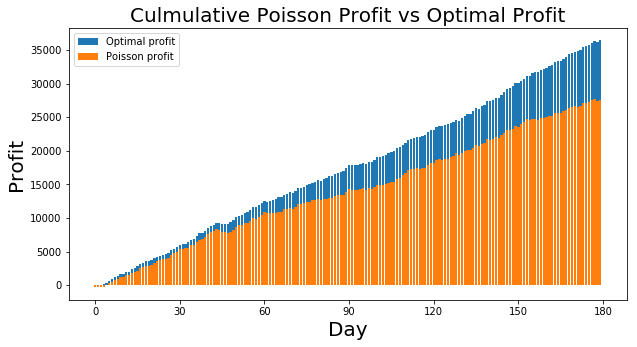

In [16]:
# 畫出累積收益比較圖
fig, ax = plt.subplots(figsize = (10, 5))

X = list(range(test_day))
# Poisson最佳訂購量
opti_y = []
for day in range(test_day):
    cul_profit = opti_y[day-1] + sum(poisson_opti_profits[day]) if day >= 1 else sum(poisson_opti_profits[day])
    opti_y.append(cul_profit)
ax.bar(X, opti_y, label = 'Optimal profit')
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))    

# Poisson 訂購max(min(E(y|x), U), L)
poisson_y = []
for day in range(test_day):
    cul_profit = poisson_y[day-1] + sum(poisson_profits[day]) if day >= 1 else sum(poisson_profits[day])
    poisson_y.append(cul_profit)
ax.bar(X, poisson_y, label = 'Poisson profit')
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))    

plt.xlabel('Day', size = 20)
plt.ylabel('Profit', size = 20)
plt.title('Culmulative Poisson Profit vs Optimal Profit', size = 20)
plt.legend()

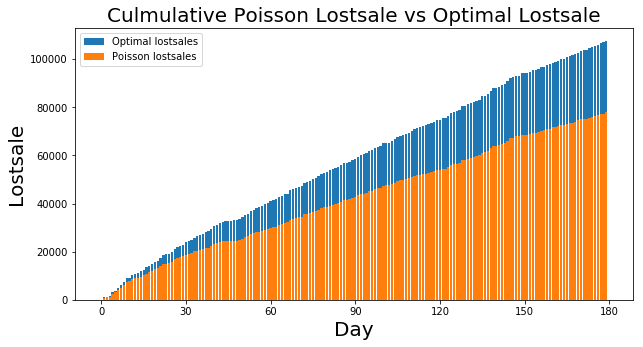

In [17]:
# 畫出累積銷售損失比較圖
fig, ax = plt.subplots(figsize = (10, 5))

X = list(range(test_day))
# Poisson最佳訂購量
opti_y = []
for day in range(test_day):
    cul_lostsale = opti_y[day-1] + sum(poisson_opti_lostsales.loc[poisson_opti_lostsales['day']==day, 'lost_sales*price']) if day >= 1 else sum(poisson_opti_lostsales.loc[poisson_opti_lostsales['day']==day, 'lost_sales*price'])
    opti_y.append(cul_lostsale)
ax.bar(X, opti_y, label = 'Optimal lostsales')
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))    

# Poisson 訂購max(min(E(y|x), U), L)
poisson_y = []
for day in range(test_day):
    cul_lostsale = poisson_y[day-1] + sum(poisson_lostsales.loc[poisson_lostsales['day']==day, 'lost_sales*price']) if day >= 1 else sum(poisson_lostsales.loc[poisson_lostsales['day']==day, 'lost_sales*price'])
    poisson_y.append(cul_lostsale)
ax.bar(X, poisson_y, label = 'Poisson lostsales')
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))    

plt.xlabel('Day', size = 20)
plt.ylabel('Lostsale', size = 20)
plt.title('Culmulative Poisson Lostsale vs Optimal Lostsale', size = 20)
plt.legend()

##### 理論最佳利潤

In [18]:
# optimal_profit：每天訂購真實需求量
optimal_profits = []
for day in range(test_day):
    day_profit = []
    for i in N:
        actual_sale = actual_sales['unit_sales'].loc[(actual_sales['item_nbr']==integer_items[i]) & (actual_sales['day']==day)].values[0]
        day_profit.append((p[i] * max(min(U[i], actual_sale), L[i])) - (c[i] * max(min(U[i], actual_sale), L[i])))
        
    optimal_profits.append(day_profit)

In [19]:
# for day in range(test_day):
#     print('第{}天的利潤: {}'.format(day, opti_profits[day]))
total_optimal_profit = sum(sum(profit) for profit in optimal_profits)
print('****總利潤: {}****'.format(total_optimal_profit))

****總利潤: 96170.0****


### 計算模型gap：
$({Profit}_{optimal} - {Profit}_{model}) / {Profit}_{optimal}$

In [20]:
# poisson_model 
print("只用poisson:", (total_optimal_profit - total_poisson_profit) / total_optimal_profit)

# poisson_opti_model
print("poisson最佳化:", (total_optimal_profit - total_poisson_opti_profit) / total_optimal_profit)


只用poisson: 0.712904232089009
poisson最佳化: 0.6210876572735781
